In [81]:
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = 'C:/Windows/Fonts/malgunbd.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.
from tqdm import tqdm

from nltk import FreqDist
from nltk import bigrams, word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud

from konlpy.tag import Okt

okt = Okt()

In [40]:
banksalad = pd.read_pickle('banksalad_review.pkl')

In [44]:
#날짜 형태 변경
banksalad['날짜'] = banksalad['날짜'].apply(lambda x: ('-').join(re.findall('[0-9]+', x)))
banksalad['날짜'] = pd.to_datetime(banksalad['날짜'])

banksalad['간격'] = banksalad['간격'].apply(lambda x: ('-').join(re.findall('[0-9]+', x)) if x != 'N' else 'N')

#전체 리뷰에 대한 답변 리뷰 비율 확인
print('답변율: {}'.format(len(banksalad[banksalad['답여부'] == 'Y']) / len(banksalad) * 100))

답변율: 99.37304075235109


In [45]:
#답변이 있는 리뷰에서 답변까지의 기간 확인
bank_reply = banksalad[banksalad['답여부'] != 'N']
bank_reply['간격'] = pd.to_datetime(bank_reply['간격'])

bank_reply['기간'] = bank_reply['간격'] - bank_reply['날짜']
bank_reply['기간'] = bank_reply['기간'].apply(lambda x: x.days) #datetime method에서 날짜 추출

C:\Users\sb\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\sb\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\sb\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [47]:
#리뷰에 대한 어플리케이션사의 답변이 해당 리뷰보다 빨리 작성된 오류가 존재
bank_reply[bank_reply['기간'] < 0]

,리뷰,날짜,답여부,간격,기간
24,"뱅크샐러드를 가계부 어플로 잘 사용하고 있어요. 가계부 달력에서 주간,월간 리뷰를 ...",2020-11-26,Y,2020-11-23,-3


In [48]:
#어플리케이션의 리뷰 답변 평균일
bank_reply[bank_reply['기간'] >= 0].mean()

기간    1.287975
dtype: float64

# 키워드 산출

In [50]:
def show_wc(df):
    okt_tokens = []
    review_list = list(df['리뷰'])
    for token in review_list:
        #영어 제거
        token = re.sub('([a-zA-Z])','',token)
        #자음, 혹은 모음만 있는 문자 제거
        token = re.sub('[ㄱ-ㅎㅏ-ㅣ]+','',token)
        #특수문자 제거
        token = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…;》\n]','',token)
        #명사만 추출
        okt_tokens.append(okt.nouns(token))

    #빈도수 기준으로 단어 추출
    vocab = FreqDist(np.hstack(okt_tokens))

    #워드 클라우드
    wc = WordCloud(width=1000, height=600, background_color="white", random_state=0, font_path='C:/Windows/Fonts/malgunbd.ttf')
    plt.figure(figsize=(20,10))
    plt.imshow(wc.generate_from_frequencies(vocab))
    plt.axis("off")
    plt.show()
    
    vocab = vocab.most_common(100)
    return vocab

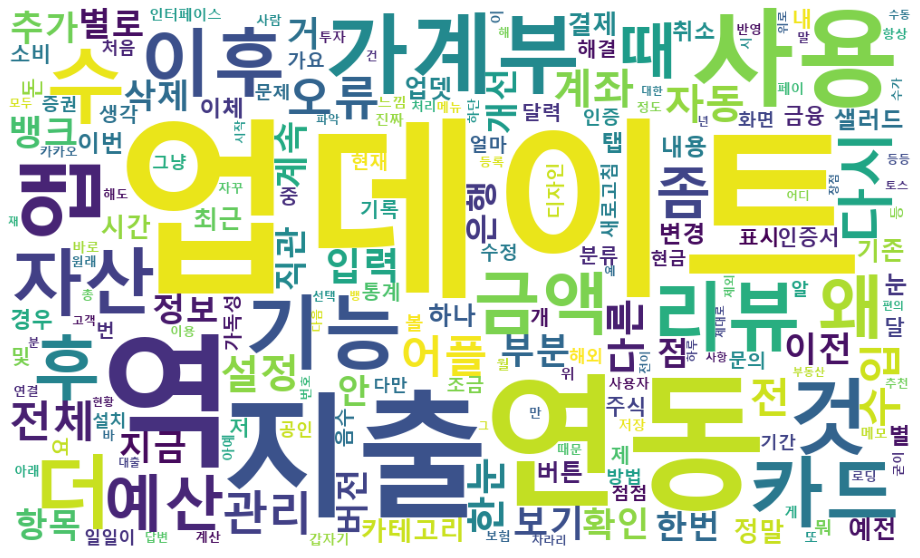

In [51]:
bank_vocab = show_wc(banksalad)

In [69]:
columns = ['vocab', 'count']
word_df = pd.DataFrame(columns=columns)

words = []
cnts = []

for word, cnt in bank_vocab:
    words.append(word)
    cnts.append(cnt)
    
word_df['vocab'] = words
word_df['count'] = cnts

word_df.set_index('vocab', inplace=True)

<BarContainer object of 50 artists>

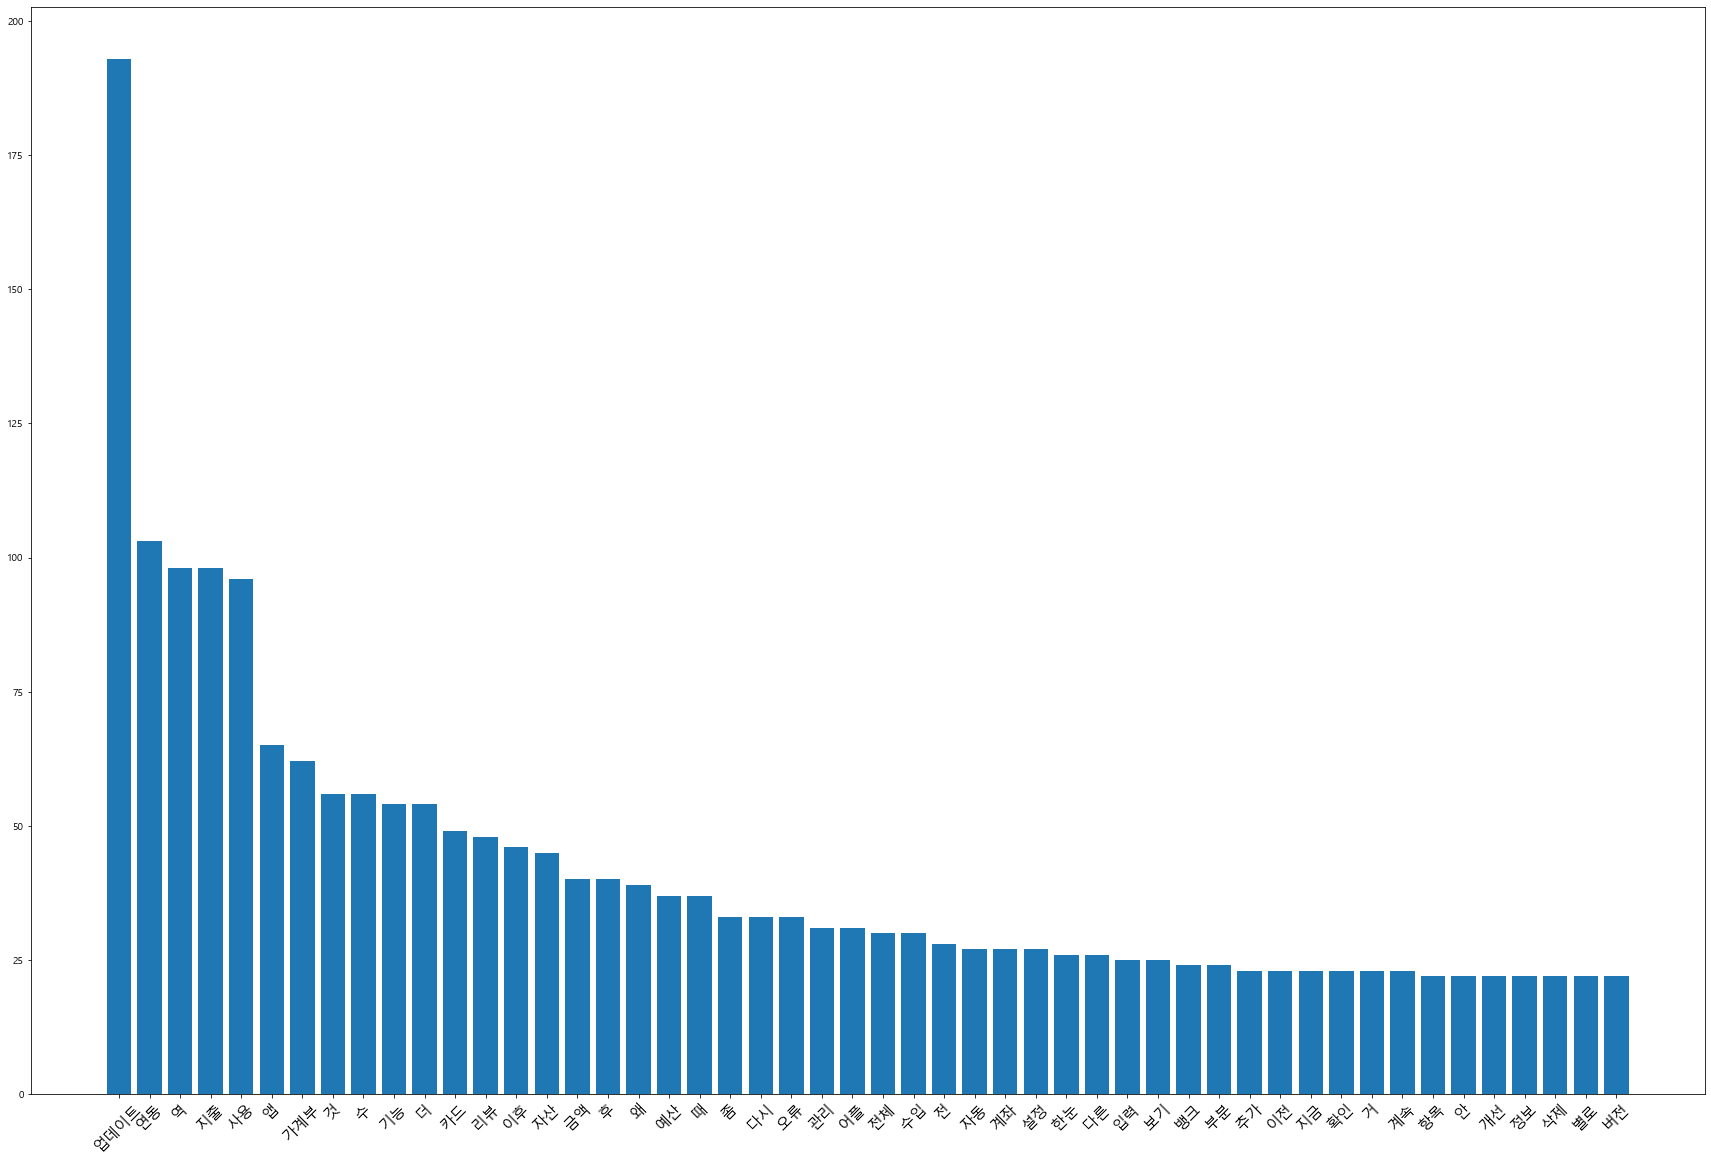

In [101]:
plt.figure(figsize=(30,20))
plt.xticks(rotation=45, size=15)
plt.bar(word_df.index[:50], word_df['count'].iloc[:50])

In [108]:
def find_review(keyword):
    rev_all = []
    for rev in banksalad['리뷰']:
        if keyword in rev:
            rev_all.append(rev)
    print(rev_all)

In [109]:
find_review('업데이트')

['장점 1. 자동으로 가계부를 써주고 평가 2. 계좌연동 3. 투자액, 집값등 비현금성자산까지 연동 4. 카드추천 5. 빠른 문제해결과 업데이트 6. 간단하고 직관적인 사용방법 단점 1. 연동로딩이 느림 2. 뿜빠이 하는 것에 대해 업뎃할 수 있는 추가 선택지가 존재하지 않음 (예산에 잡혀서 실제 예산 얼마나 썼는지가 업뎃이 안됨) 3. 카카오뱅크 대출은 연동안됨', '업데이트 이후 너무 불편해졌어요. 이전에는 사용이 직관적이라 편했는데 지금은 지출/수입/이체의 색깔도 너무 비슷해서 한눈에 보기 힘들고 기타 여러가지 기능들도 쓰기가 불편합니다. 다른 사용자들도 이런 의견이 많은거 같은데, 좀 엉뚱하게 하지 않아도 될 업데이트를 한듯 싶어요. 이전으로 되돌렸으면 좋겠네요 ㅠㅠ', '잘 사용중입니다. 이번 업데이트 말고 저번 업데이트 전 베타시스템인 자산 증가 현황 그래프가 있었는데 지금도 있긴하지만 예전에는 1월 달부터였고 그달 자산을 확인할수있었지만 현재는 최근 몇달이며 지난달 자산을 확인할수없어서 아쉬워요 ㅠㅠㅠ 개선해주세요 ㅠㅠ 그치만 너무 잘 사용중이라 감사합니다.', '앱 잘쓰고있습니다. 다만 최근 UI 업데이트 이후에 자동업데이트가 일관되지 않게 이루어지는데 왜 이런 현상이 일어나는지 모르겠네요. 수동 업데이트 버튼도 사라져서 자동으로 업데이트 될 때까지 기다려야만 되는데 원래처럼 수동으로 업데이트 하는 방법은 없나요?', '삼년전에 깔았다가 삭제하고 이번에 다시 깔았는데 아무리 업데이트를 하고 새로 연동을 해봐도 3년 전 기록이네요 ㅡㅡ 잔액도 대출도 그 당시로 자꾸 표시되네요. 무쓸모에요. 제 은행정보만 전부 노출된 것 같아서 굉장히 찝찝해요.', '음수 입력은 왜 막아둔건지요... 한번에 긁고 친구들한테 받은 경우에는 지출에 음수입력을 해서 결제취소분으로 처리 하는쪽이 훨씬 편할텐데... 게다가 예산에서 제외 버튼을 누르면 뜨는 팝업창때문에 저장 버튼이 가려져서 강제로 기다럈다가 눌러야 되네요 ㅋㅋㅋㅋ 이거 업데이트는 왜 하신건가요? 더 불편할